<a href="https://colab.research.google.com/github/dh610/Advanced-AI/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# InstructIR ✏️🖼️
## High-Quality Image Restoration Following Human Instructions

[Marcos V. Conde](https://scholar.google.com/citations?user=NtB1kjYAAAAJ&hl=en), [Gregor Geigle](https://scholar.google.com/citations?user=uIlyqRwAAAAJ&hl=en), [Radu Timofte](https://scholar.google.com/citations?user=u3MwH5kAAAAJ&hl=en)


Original Code and Material: [https://github.com/mv-lab/InstructIR](https://github.com/mv-lab/InstructIR)

<a href="https://github.com/mv-lab/InstructIR"><img src="https://i.ibb.co/Xp5bJ7n/instructir-teaser.png" alt="InstructIR" border="0"></a>


<br>

> **Abstract:** Image restoration is a fundamental problem that involves recovering a high-quality clean image from its degraded observation. All-In-One image restoration models can effectively restore images from various types and levels of degradation using degradation-specific information as prompts to guide the restoration model. In this work, we present the first approach that uses human-written instructions to guide the image restoration model. Given natural language prompts, our model can recover high-quality images from their degraded counterparts, considering multiple degradation types. Our method, InstructIR, achieves state-of-the-art results on several restoration tasks including image denoising, deraining, deblurring, dehazing, and (low-light) image enhancement. InstructIR improves +1dB over previous all-in-one restoration methods. Moreover, our dataset and results represent a novel benchmark for new research on text-guided image restoration and enhancement.

### 1. Download code from the official github: https://github.com/mv-lab/InstructIR

In [3]:
import sys
import os

sys.path.append("/content/drive/MyDrive/Advanced-AI/InstructIR/")
os.chdir("/content/drive/MyDrive/Advanced-AI/InstructIR/")
!ls

app.py	  datasets.py	      index.html  predict.py		   results    text
cog.yaml  demo.ipynb	      LICENSE	  __pycache__		   static     utils.py
configs   eval_instructir.py  metrics.py  README.md		   test-data
data	  images	      models	  requirements_gradio.txt  test.py


In [4]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import yaml
import random
import torch

from utils import *
from models import instructir

from text.models import LanguageModel, LMHead

SEED=42
seed_everything(SEED=SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Check the config file at `configs/eval5d.yml` for more context.

In [5]:
CONFIG     = "configs/eval5d.yml"
LM_MODEL   = "models/lm_instructir-7d.pt"
MODEL_NAME = "models/im_instructir-7d.pt"

# parse config file
with open(os.path.join(CONFIG), "r") as f:
    config = yaml.safe_load(f)

cfg = dict2namespace(config)

Create the InstructIR model using the provided pre-trained weights at `models/`.
- You will need to load the image model `im_`
- and the language model `lm_`

In [6]:
!ls models/

im_instructir-7d.pt  instructir.py  lm_instructir-7d.pt  nafnet.py  nafnet_utils.py  __pycache__


In [12]:
print ("Creating InstructIR")
model = instructir.create_model(input_channels =cfg.model.in_ch, width=cfg.model.width, enc_blks = cfg.model.enc_blks,
                            middle_blk_num = cfg.model.middle_blk_num, dec_blks = cfg.model.dec_blks, txtdim=cfg.model.textdim)

print (device)
model = model.to(device)

################### LOAD IMAGE MODEL

Creating InstructIR
cuda


In [13]:
################### LANGUAGE MODEL

if cfg.model.use_text:
    os.environ["TOKENIZERS_PARALLELISM"] = "false"

    # Initialize the LanguageModel class
    LMODEL = cfg.llm.model
    language_model = LanguageModel(model=LMODEL)
    lm_head = LMHead(embedding_dim=cfg.llm.model_dim, hidden_dim=cfg.llm.embd_dim, num_classes=cfg.llm.nclasses)
    lm_head = lm_head.to(device)
    lm_nparams   = count_params (lm_head)

    print ("LMHEAD MODEL CKPT:", LM_MODEL)
    lm_head.load_state_dict(torch.load(LM_MODEL, map_location=torch.device('cpu')), strict=True)
    print ("Loaded weights!")

else:
    LMODEL = None
    language_model = None
    lm_head = None
    lm_nparams = 0

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/745 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/34.8M [00:00<?, ?B/s]

LMHEAD MODEL CKPT: models/lm_instructir-7d.pt


<ipython-input-13-8b631cff36b2>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lm_head.load_state_dict(torch.load(LM_MODEL, map_location=torch.device('cpu')), strict=True

Loaded weights!


In [27]:
lm_embd = language_model("I want my photo to be clear, not rainy").to(device)
text_embd, deg_pred = lm_head (lm_embd)

torch.argmax(deg_pred)

tensor(2, device='cuda:0')

In [28]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torch
import torch.optim as optim
import torch.nn as nn

# 데이터셋 경로 설정
input_dir = '/content/drive/MyDrive/Advanced-AI/InstructIR/test-data/Rain100L/input'
target_dir = '/content/drive/MyDrive/Advanced-AI/InstructIR/test-data/Rain100L/target'

# 커스텀 데이터셋 정의
class ImagePairDataset(Dataset):
    def __init__(self, input_dir, target_dir, transform=None):
        self.input_dir = input_dir
        self.target_dir = target_dir
        self.transform = transform
        self.image_filenames = [f for f in os.listdir(input_dir) if f.endswith('.png')]  # 이미지 파일 이름 리스트

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # 입력 이미지 (열화된 이미지)
        input_image_path = os.path.join(self.input_dir, self.image_filenames[idx])
        input_image = Image.open(input_image_path).convert("RGB")

        # 대상 이미지 (원본 이미지)
        target_image_path = os.path.join(self.target_dir, self.image_filenames[idx])
        target_image = Image.open(target_image_path).convert("RGB")

        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        return input_image, target_image  # 열화된 이미지와 원본 이미지 반환

# 이미지 전처리를 위한 transforms (원하는 대로 수정 가능)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # 이미지 크기 조정 (필요 시)
    transforms.ToTensor()  # 이미지를 Tensor로 변환
])

# 전체 데이터셋 로드
dataset = ImagePairDataset(input_dir=input_dir, target_dir=target_dir, transform=transform)

# 데이터셋을 9:1로 나눔 (90% 학습, 10% 테스트)
train_size = int(0.9 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 모델 학습 설정 (기본 구조는 동일)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)



InstructIR(
  (intro): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (ending): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (encoders): ModuleList(
    (0): Sequential(
      (0): NAFBlock(
        (conv1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64)
        (conv3): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (sca): Sequential(
          (0): AdaptiveAvgPool2d(output_size=1)
          (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (sg): SimpleGate()
        (conv4): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
        (conv5): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (norm1): LayerNorm2d()
        (norm2): LayerNorm2d()
        (dropout1): Identity()
        (dropout2): Identity()
      )
      (1): NAFBlock(
        (conv1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1))
        

In [29]:
# 학습 루프
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for input_images, target_images in train_loader:
        input_images, target_images = input_images.to(device), target_images.to(device)

        # 기울기 초기화
        optimizer.zero_grad()

        # 순전파
        outputs = model(input_images, text_embd)  # text_embd는 미리 생성된 임베딩
        loss = criterion(outputs, target_images)  # 복원된 이미지와 원본 이미지 간의 차이 계산

        # 역전파 및 최적화
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader)}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 128.00 MiB. GPU 0 has a total capacity of 39.56 GiB of which 46.81 MiB is free. Process 18932 has 39.51 GiB memory in use. Of the allocated memory 38.99 GiB is allocated by PyTorch, and 30.09 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:

# 테스트셋 평가
model.eval()  # 평가 모드로 전환
test_loss = 0.0
with torch.no_grad():  # 평가 시에는 기울기 계산을 하지 않음
    for input_images, target_images in test_loader:
        input_images, target_images = input_images.to(device), target_images.to(device)

        outputs = model(input_images, text_embd)  # 예측
        loss = criterion(outputs, target_images)  # 테스트셋에 대한 손실 계산
        test_loss += loss.item()

print(f"Test Loss: {test_loss / len(test_loader)}")

In [ ]:
print ("Creating InstructIR")
model = instructir.create_model(input_channels =cfg.model.in_ch, width=cfg.model.width, enc_blks = cfg.model.enc_blks,
                            middle_blk_num = cfg.model.middle_blk_num, dec_blks = cfg.model.dec_blks, txtdim=cfg.model.textdim)

print (device)
model = model.to(device)

################### LOAD IMAGE MODEL

assert MODEL_NAME, "Model weights required for evaluation"

print ("IMAGE MODEL CKPT:", MODEL_NAME)
model.load_state_dict(torch.load(MODEL_NAME, map_location=torch.device('cpu')), strict=True)

nparams   = count_params (model)
print ("Loaded weights!", nparams / 1e6)

Creating InstructIR
cuda
IMAGE MODEL CKPT: models/im_instructir-7d.pt


<ipython-input-17-9692b85970f2>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_NAME, map_location=torch.device('cpu')), strict=True

Loaded weights! 15.843363


In [ ]:
################### LANGUAGE MODEL

if cfg.model.use_text:
    os.environ["TOKENIZERS_PARALLELISM"] = "false"

    # Initialize the LanguageModel class
    LMODEL = cfg.llm.model
    language_model = LanguageModel(model=LMODEL)
    lm_head = LMHead(embedding_dim=cfg.llm.model_dim, hidden_dim=cfg.llm.embd_dim, num_classes=cfg.llm.nclasses)
    lm_head = lm_head.to(device)
    lm_nparams   = count_params (lm_head)

    print ("LMHEAD MODEL CKPT:", LM_MODEL)
    lm_head.load_state_dict(torch.load(LM_MODEL, map_location=torch.device('cpu')), strict=True)
    print ("Loaded weights!")

else:
    LMODEL = None
    language_model = None
    lm_head = None
    lm_nparams = 0

LMHEAD MODEL CKPT: models/lm_instructir-7d.pt
Loaded weights!


<ipython-input-32-8b631cff36b2>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lm_head.load_state_dict(torch.load(LM_MODEL, map_location=torch.device('cpu')), strict=True

# Running InstructIR!

In [ ]:
def process_img (image, prompt):
    """
    Given an image and a prompt, we run InstructIR to restore the image following the human prompt.
    image: RGB image as numpy array normalized to [0,1]
    prompt: plain python string,

    returns the restored image as numpy array.
    """

    # Convert the image to tensor
    y = torch.Tensor(image).permute(2,0,1).unsqueeze(0)
    y = y.to(device)

    # Get the text embedding (and predicted degradation class)
    lm_embd = language_model(prompt)
    lm_embd = lm_embd.to(device)
    text_embd, deg_pred = lm_head (lm_embd)

    # Forward pass: Paper Figure 2
    x_hat = model(y, text_embd)

    # convert the restored image <x_hat> into a np array
    restored_img = x_hat[0].permute(1,2,0).cpu().detach().numpy()
    restored_img = np.clip(restored_img, 0. , 1.)
    return restored_img

You need to feed into the function and RGB image and a simple instruction (string).

Check `load_img` from `utils.py` we just use PIL to load a given image.
You can find more sample images in `images/`

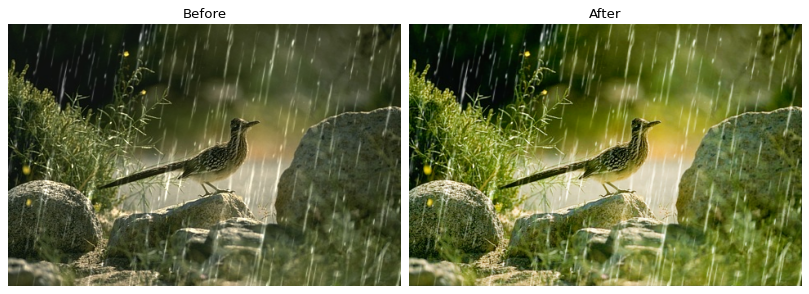

In [ ]:
IMG    = "images/rain-020.png"
PROMPT = "Retouch the picture as a professional photographer please"

image = load_img(IMG)
restored_image = process_img(image, PROMPT )
# save_rgb (restored_image, "result.png") # save the resultant image
plot_all([image, restored_image], names=["Before", "After"], figsize=(10,5))

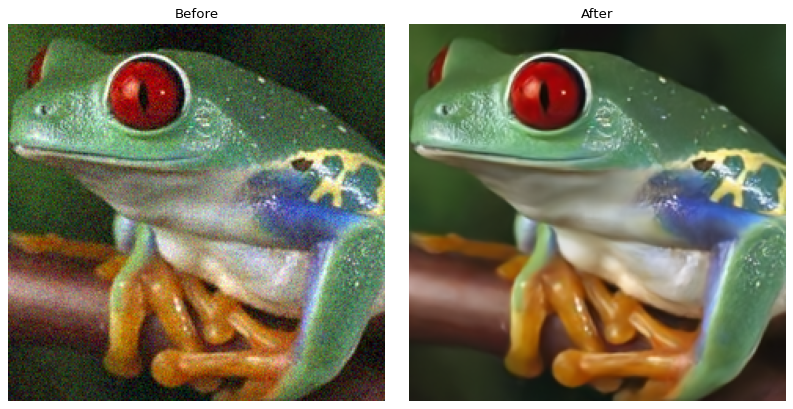

In [ ]:
IMG    = "images/frog.png" # from RealSRSet
PROMPT = "Can you remove the little dots in the image? is very unpleasant"

image = load_img(IMG)
restored_image = process_img(image, PROMPT )
# save_rgb (restored_image, "result.png") # save the resultant image
plot_all([image, restored_image], names=["Before", "After"], figsize=(10,5))

### Control the process

Sometimes the blur, rain, or film grain noise are pleasant effects and part of the **"aesthetics"**.

Here we show a simple example on how to interact with InstructIR
> Disclaimer: please remember this is not a product, thus, you will notice some limitations.

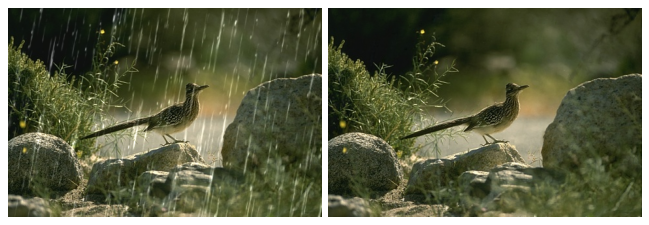

In [ ]:
IMG    = "images/rain-020.png"
image  = load_img(IMG)

PROMPT1 = "I love this photo, could you remove the raindrops? please keep the content intact"
result1 = process_img(image, PROMPT1 )
plot_all([image, result1], figsize=(8,4))

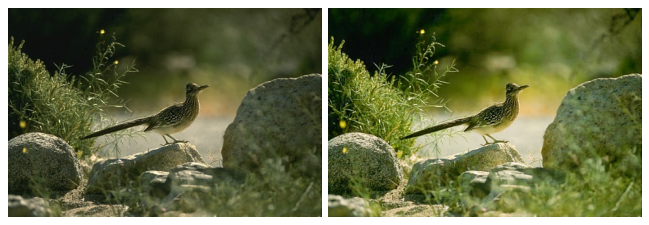

In [ ]:
PROMPT2 = "Can you make it look stunning? like a professional photo"
result2 = process_img(result1, PROMPT2 )
plot_all([result1, result2], figsize=(8,4))

The final result looks indeed stunning :)

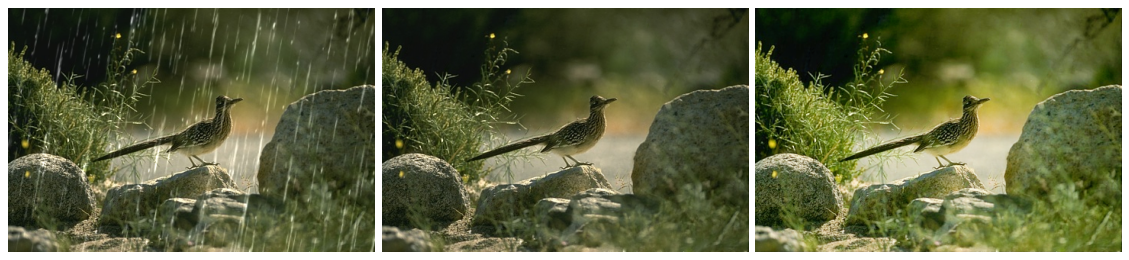

In [ ]:
plot_all([image, result1, result2], figsize=(14,7))